## **Image Classification on Fashion MNIST with TensorFlow-Quantum and Cirq**

**About the Dataset and QML**

The original MNIST dataset contains a lot of handwritten digits. People from AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset they would try on. “If it doesn’t work on MNIST, it won’t work at all”, they said. “Well, if it does work on MNIST, it may still fail on others.” Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset to benchmark machine learning algorithms, as it shares the same image size and the structure of training and testing splits.

We shall perform QML on Fashion MNIST dataset using TensorFLow Quantum and Cirq.

TensorFlow-Quantum is a great place to start learning QML and get into this amazing field. TensorFlow Quantum (TFQ) is a quantum machine learning library for rapid prototyping of hybrid quantum-classical ML models.TensorFlow Quantum focuses on quantum data and building hybrid quantum-classical models. It integrates quantum computing algorithms and logic designed in Cirq, and provides quantum computing primitives compatible with existing TensorFlow APIs, along with high-performance quantum circuit simulators.

Cirq is a Python software library for writing, manipulating, and optimizing quantum circuits, and then running them on quantum computers and quantum simulators. Cirq provides useful abstractions for dealing with today’s noisy intermediate-scale quantum computers, where details of the hardware are vital to achieving state-of-the-art results.

Today's(NISQ Era) Quantum Computer are not very powerful and have various limitations. Also, the field of Quantum Machine Learning is currently evolving. To keep things simple, we will modify the Fashion MNIST dataset by making classification on only two classes - Sandal and Ankle boot. The reason to choose these classes is that they are similar to each other and therefore, it ascertains that the classification problem doesn't become very easy. The image shape in the provided dataset is (28,28), but we need to downscale the images to classify them using QML due to the hardware restrictions. We will downscale the images so that they have the shape (4,4).

Number of Images in the Train Dataset - 10200

Number of Images in the Validation Dataset - 1800

Number of Images in the Test Dataset - 2000

Size of each Image - (2,2)

Type of Image - Grayscale Image

Number of Labels - 2

Label                                             Description


5                                                  Sandal

9                                                  Ankle boot

In [1]:
# installing TensorFLow Version 2.3.1
from IPython.display import clear_output
!pip install -q tensorflow==2.3.1
clear_output()

In [2]:
# install tensorflow quantum
!pip install -q tensorflow_quantum==0.4.0
clear_output()

In [3]:
#install cirq
!pip install cirq==0.9.1
clear_output()

**Importing the dataset and required packages**

In [4]:
import tensorflow as tf

# Data Processing tools
import numpy as np
from sklearn.model_selection import train_test_split 

# QML tools
import tensorflow_quantum as tfq
import cirq
import sympy

# Visualization Tools
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

In [5]:
#Lets print the version of cirq and tfq that we will use
print("We are using the TensorFlow-Quantum version {}".format(tfq.__version__))
print("We are using the Cirq version {}".format(cirq.__version__))

We are using the TensorFlow-Quantum version 0.4.0
We are using the Cirq version 0.9.1


In [6]:
#importing the Fashion MNIST dataset from keras
from tensorflow.keras.datasets import fashion_mnist as dataset

In [7]:
(X_train, y_train), (X_test, y_test) = dataset.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [8]:
print("The shape of the X_train is {}".format( X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_test is {}".format(X_test.shape))
print("The shape of the y_test is {}".format(y_test.shape))

The shape of the X_train is (60000, 28, 28)
The shape of the y_train is (60000,)
The shape of the X_test is (10000, 28, 28)
The shape of the y_test is (10000,)


**Preprocessing the Dataset**

In [9]:
def filter_data(x, y):
  """
  Helper Function to filter the dataset
  """
  #filter the data using labels
  keep = (y == 5) | (y == 9)
  x, y = x[keep], y[keep]

  # convert labels to boolean
  # y = True if y==5
  # y = False if y==9
  y = y == 5
  return x,y

In [10]:
#Filter the train set
X_train, y_train = filter_data(X_train, y_train)

#Filter the test_set
X_test, y_test = filter_data(X_test, y_test)

In [11]:
# Let's have a look at the shapes of train and test data
print("The shape of the X_train is {}".format( X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_test is {}".format(X_test.shape))
print("The shape of the y_test is {}".format(y_test.shape))

The shape of the X_train is (12000, 28, 28)
The shape of the y_train is (12000,)
The shape of the X_test is (2000, 28, 28)
The shape of the y_test is (2000,)


The First Image has the label False


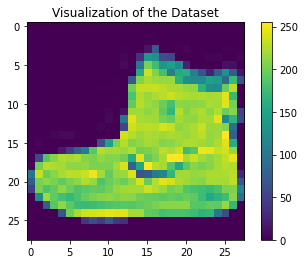

In [12]:
#Let's have a look at the first image from our X_train and the 
# corresponding label from y_train
print("The First Image has the label {}".format(y_train[0]))
plt.imshow(X_train[0])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

From the colorbar in the above visualization, it is clear that we have grayscale images in the dataset and hence their values range from 0 to 255. However, we would like to scale these pixel values in our dataset so that the values range from 0 to 1. This will help us to converge our CNN training faster

In [13]:
#Normalizing the train and test image data
X_train = X_train/255.0
X_test = X_test/ 255.0

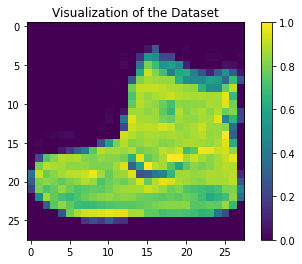

In [14]:
#Let's again have a look at the first image from our X_train and
#see if we have successfully normalized the datasets
plt.imshow(X_train[0])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

In [15]:
#Before proceeding, we need to reshape our images in the dataset
X_train = X_train.reshape(X_train.shape[0], *(28,28,1))
X_test = X_test.reshape(X_test.shape[0], *(28,28,1))

In [16]:
# Downscaling the images
X_train = tf.image.resize(X_train, (2,2)).numpy()
X_test = tf.image.resize(X_test, (2,2)).numpy()

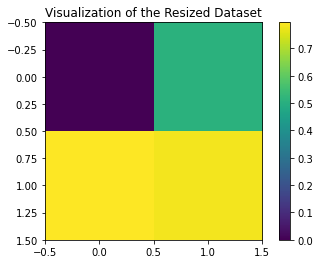

In [17]:
#Let's again have a look at the first image from our resized X_train
plt.imshow(X_train[0,:,:,0])
plt.colorbar()
plt.title('Visualization of the Resized Dataset')
plt.show()

In [18]:
#Splitting the training fdataset into train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state=0)

In [19]:
print("The shape of the X_train is {}".format(X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_valid is {}".format(X_valid.shape))
print("The shape of the y_valid is {}".format(y_valid.shape))

The shape of the X_train is (10200, 2, 2, 1)
The shape of the y_train is (10200,)
The shape of the X_valid is (1800, 2, 2, 1)
The shape of the y_valid is (1800,)


**Data Encoding**

Steps involved in Data Encoding:

Processing pixel values for binary encoding

Converting Cirq Circuits to tfq tensors

**Step 1: Processing Pixel Values for Binary Encoding**

In [20]:
# FLattening the images
X_train = X_train.reshape(X_train.shape[0], *(1,4,1))
X_valid = X_valid.reshape(X_valid.shape[0], *(1,4,1))
X_test = X_test.reshape(X_test.shape[0], *(1,4,1))

**Processing X_train**

In [21]:
#Let's have a look on the first example
print(X_train[0])

[[[0.        ]
  [0.41568628]
  [0.7137255 ]
  [0.73921573]]]


In [22]:
def binary_encode(X,threshold=0.5):
  """
  Encodes the given datset to use binary encoding

  Parameters:
  X(array) : Image data to be processed for encoding
  threshold(float): Threshold for binary encoding, 0.5 by default

  Returns:
  encoded_images(array): Binary encoded Image Data

  """ 
  encoded_images = list()
  for image in X:
    # pixel value is 1 if it's greater than threshold or else zero
    encoded_image = [1 if j>threshold else 0 for j in image[0]]
    encoded_images.append(encoded_image)
  return np.array(encoded_images)

In [23]:
X_train = binary_encode(X_train)

In [24]:
# Now, Let's have a look on the first example again
print(X_train[0])

[0 0 1 1]


In [25]:
print("The shape of the X_train is {}".format(X_train.shape))

The shape of the X_train is (10200, 4)


In [26]:
def create_circuit_from_image(encoded_image):
  """
  Returns a circuit for given encoded image

  Parameters:
  encoded_image (array): Encoded Image

  Returns:
  circuit (cirq.Circuit object): cirq circuit
  """
  qubits = cirq.GridQubit.rect(2,2)
  circuit = cirq.Circuit()
  for i, pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [27]:
X_train = [create_circuit_from_image(encoded_image) for encoded_image in X_train]

In [28]:
# Let's have a look at the circuit for the first image
print(X_train[0])

(1, 0): ───X───

(1, 1): ───X───


Recall that the values for the first image were 0,0,1,1. This implies that we should apply X or NOT gate the last two qubuts since all the qubits are intially in the 0 states. Applying a X gate will change this state from zero to one. Therefore, we shall apply X Gate on the last two qubits. We have initialized the four qubits in a rectangular grid. Therefore, the initialized qubits are (0,0), (0,1), (1,0) and (1,1). In the above circuit diagram, note that we have a X gate on the qubits (1,0) and (1,1) which are the last two qubits. Hence, we have successfully created circuit for our image.

**Step 2: Converting Cirq Circuits to tfq Tensors**

In [29]:
X_train_tfq = tfq.convert_to_tensor(X_train)

**Processing X_valid and X_test**

In [30]:
X_valid = binary_encode(X_valid)
X_test = binary_encode(X_test)

In [31]:
X_valid = [create_circuit_from_image(encoded_image) for encoded_image in X_valid]
X_test = [create_circuit_from_image(encoded_image) for encoded_image in X_test]

In [32]:
X_valid_tfq = tfq.convert_to_tensor(X_valid)
X_test_tfq = tfq.convert_to_tensor(X_test)

**Quantum Neural Network**

Build the QNN

Building the Quantum Neural Network involves two steps:

Build a class that adds gates layer by layer.

Define the QNN using the class from the above step.

In [33]:
class QNN():
    def __init__(self, data_qubits, readout):
      self.data_qubits = data_qubits
      self.readout = readout

    def add_singleQubit_gate(self,circuit, gate, qubit_index):
      """
      Adds single qubit gate to the circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      qubits(list): index of qubits to apply the gate 
      Returns:
      None
      """
      for index in qubit_index:
        circuit.append(gate(self.data_qubits[index]))

    def add_twoQubit_gate(self,circuit, gate, qubit_index):
      """
      Adds two qubit gate to the circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      qubits(list): index of qubits to apply the gate
      Returns:
      None
      """
      if len(qubit_index)!=2:
        raise Exception("The length of the list of indices passed for two qubit \
        gate operations must be equal to two")
      circuit.append(gate(self.data_qubits[qubit_index[0]], self.data_qubits[qubit_index[1]]))

    def add_layer(self, circuit, gate, symbol_gate):
      """
      Adds New Gates/Layers to the Circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      symbol_gate(string): symbol for the gate
      Returns:
      None
      """
      for i, qubit in enumerate(self.data_qubits):
        symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
        circuit.append(gate(qubit, self.readout)**symbol)

In [34]:
def create_qnn():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(2,2)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    qnn = QNN(
        data_qubits = data_qubits,
        readout=readout)
    
    """
    # Though we don't use single and double Qubit Gates in our Circuit, we provide 
    # the methods "add_singleQubit_gate" and "add_twoQubit_gate" for our Class QNN
    # that can be used to add Single and Double Qubit Gates respectively.
    # An exmaple is shown below:

    #Add Hadamard Gates
    qnn.add_singleQubit_gate(circuit, cirq.H, [0,1,2,3])

    #Add CNOT gates
    qnn.add_twoQubit_gate(circuit, cirq.CNOT, [0, 1])
    qnn.add_twoQubit_gate(circuit, cirq.CNOT, [2, 3])
    """

    # Add the ising coupling XX gate
    qnn.add_layer(circuit, cirq.XX, "xx")
    qnn.add_layer(circuit, cirq.ZZ, "zz")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [35]:
qmodel, model_readout = create_qnn()

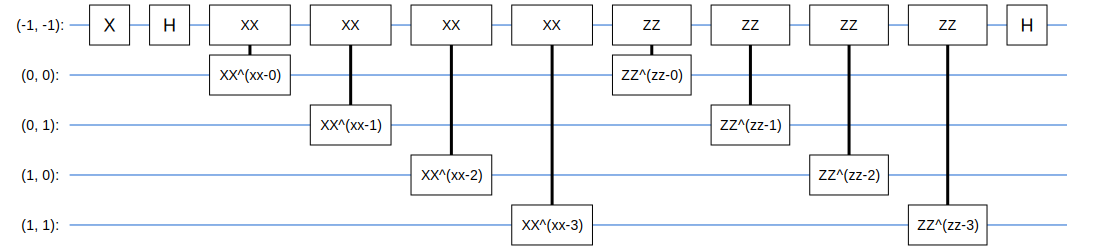

In [36]:
#Let's have a look at our Quantum Circuit that will perform the classification
SVGCircuit(qmodel)

In [37]:
model = tf.keras.Sequential([
                             
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),

    
    # The PQC stands for Paramaterized Quantum Circuit
    # This returns the expectation value
    tfq.layers.PQC(qmodel, model_readout),
])

In [38]:
# To use Hinge Loss, we convert the labels to 1 and -1
y_train_h = np.array([1 if i==1 else -1 for i in y_train ])
y_valid_h = np.array([1 if i==1 else -1 for i in y_valid ])
y_test_h = np.array([1 if i==1 else -1 for i in y_test ])

In [39]:
# Let's have a look at the first label from the training dataset
print(y_train_h[0])

1


In [40]:
# Define the custom Hinge Accuracy
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

**Train the QNN**

In [41]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[hinge_accuracy])

In [42]:
qnn_history = model.fit(
      X_train_tfq, y_train_h,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(X_valid_tfq, y_valid_h))

Epoch 1/10
160/160 [==============================] - 5s 32ms/step - loss: 0.8287 - hinge_accuracy: 0.7241 - val_loss: 0.6203 - val_hinge_accuracy: 0.7845
Epoch 2/10
160/160 [==============================] - 4s 25ms/step - loss: 0.5055 - hinge_accuracy: 0.8074 - val_loss: 0.4303 - val_hinge_accuracy: 0.8351
Epoch 3/10
160/160 [==============================] - 3s 19ms/step - loss: 0.4137 - hinge_accuracy: 0.8147 - val_loss: 0.4077 - val_hinge_accuracy: 0.7958
Epoch 4/10
160/160 [==============================] - 3s 19ms/step - loss: 0.3987 - hinge_accuracy: 0.8022 - val_loss: 0.4046 - val_hinge_accuracy: 0.7958
Epoch 5/10
160/160 [==============================] - 3s 22ms/step - loss: 0.3950 - hinge_accuracy: 0.8023 - val_loss: 0.4031 - val_hinge_accuracy: 0.7958
Epoch 6/10
160/160 [==============================] - 5s 32ms/step - loss: 0.3938 - hinge_accuracy: 0.8023 - val_loss: 0.4028 - val_hinge_accuracy: 0.7958
Epoch 7/10
160/160 [==============================] - 3s 21ms/step - l

In [43]:
model.evaluate(X_test_tfq, y_test_h)

63/63 [==============================] - 1s 9ms/step - loss: 0.3679 - hinge_accuracy: 0.8229


[0.3678557574748993, 0.8229166865348816]

**Visualize the Results**

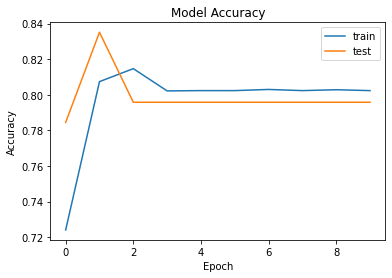

In [44]:
# Visualize Accuracy
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

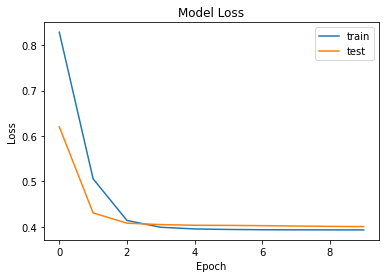

In [45]:
# Visualize Loss
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'],loc="best")
plt.show()

**Save The Model Weights**

In [47]:
#Saving the weights
model.save_weights('/content/QModelWeights')